In [1]:
file_names = ['0yTEcgQNoQo', 'b85zz8XkVO4', 'FD7ASrSrQk4', 'gQY-5f_w6oU']
detection_folders = r'\\Desktop-0331tte\d\chiletv-testdata\detection\S1-none@{fps}FPS'
video_file = r'\\Desktop-0331tte\d\chiletv-testdata\video\{name}.mp4'
out_file = r'videos\{name}.mp4'

In [2]:
import cv2
import json
from pathlib import Path
from datetime import timedelta
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt

def read_data(path):
    with path.open('r', encoding='utf8') as fp:
        obj = json.load(fp)
    x = np.float32(obj['time'])
    y = np.float32(obj['content_delta'])
    i = np.argsort(x)
    return x[i], y[i]

def video_read(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame
        
def place_text(frame, text, color):
    h, w = frame.shape[:2]
    return cv2.putText(frame, text, (0, h), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

In [3]:
key_agg = 'aggregate'
data = {file_name: {} for file_name in chain(file_names, [key_agg])}
for fps in [3, 6, 15, 30]:
    x_agg = []
    y_agg = []
    for path in Path(detection_folders.format(fps=fps)).glob('**/*.detections.json'):
        file_name = path.name[:path.name.index('.')]
        x, y = read_data(path)
        x_agg.append(x)
        y_agg.append(y)
        if file_name in file_names:
            data[file_name][fps] = (x, y)
    data[key_agg][fps] = np.concatenate(x_agg), np.concatenate(y_agg)

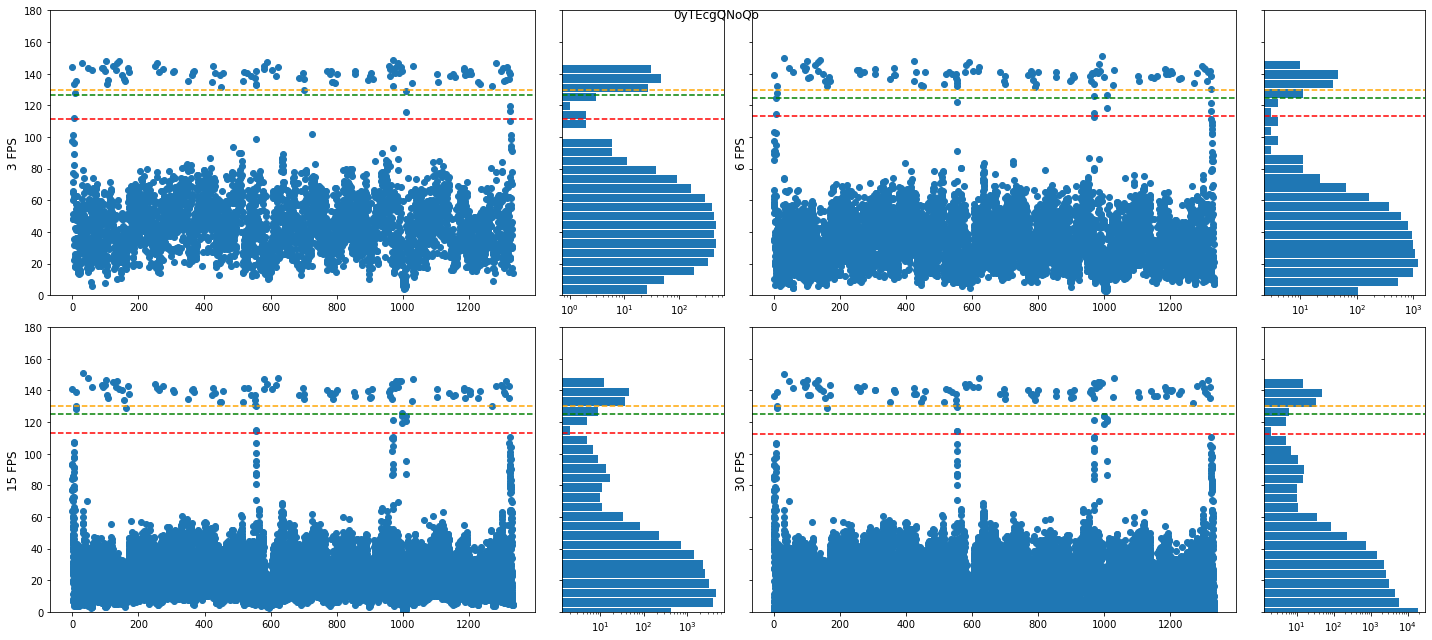

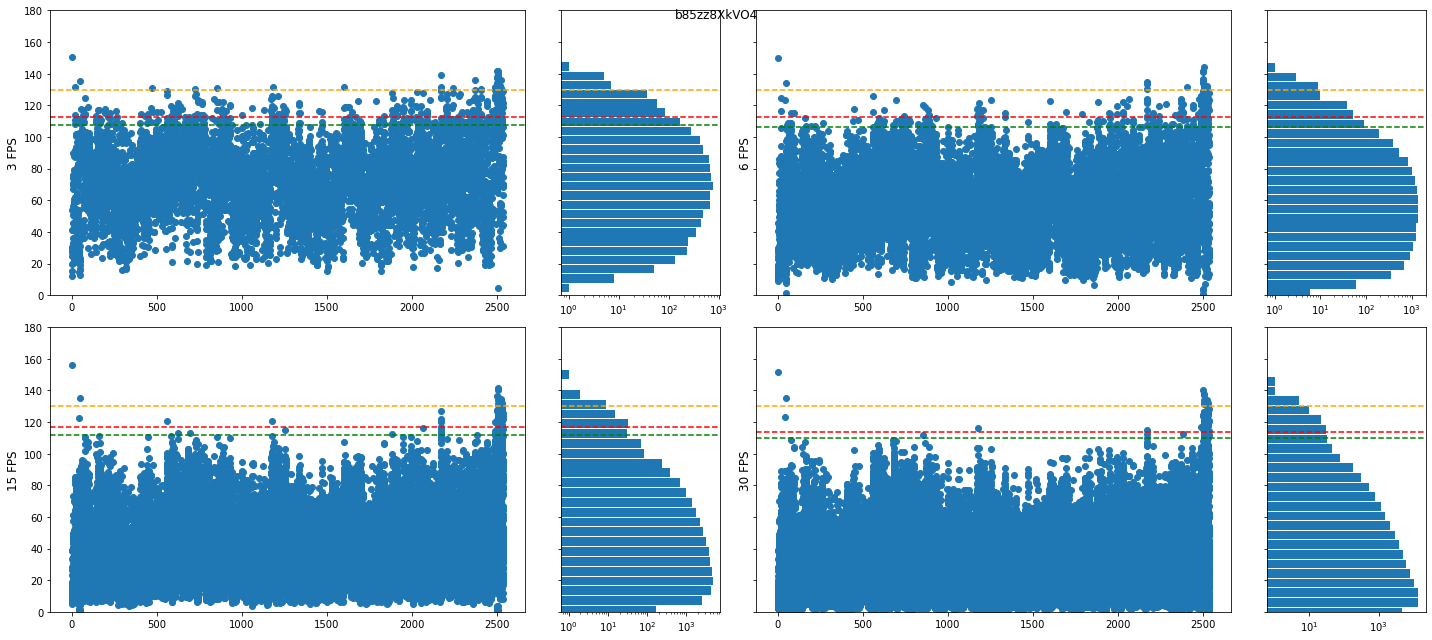

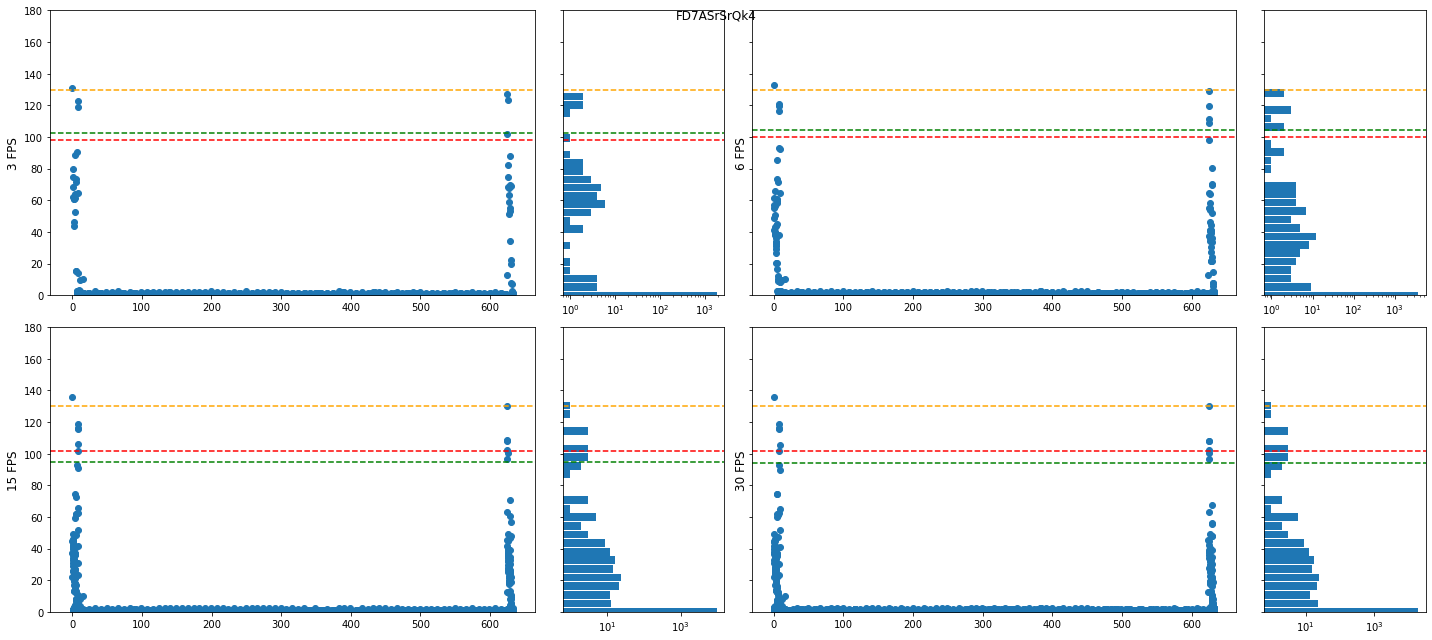

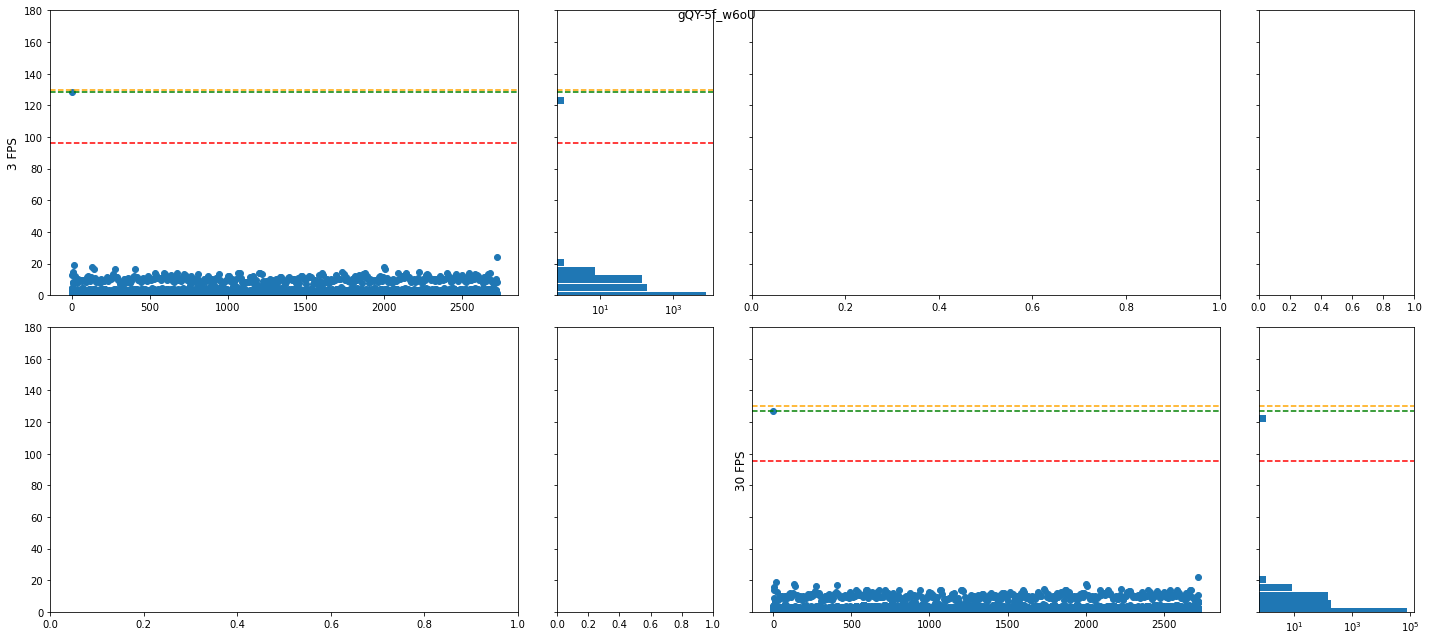

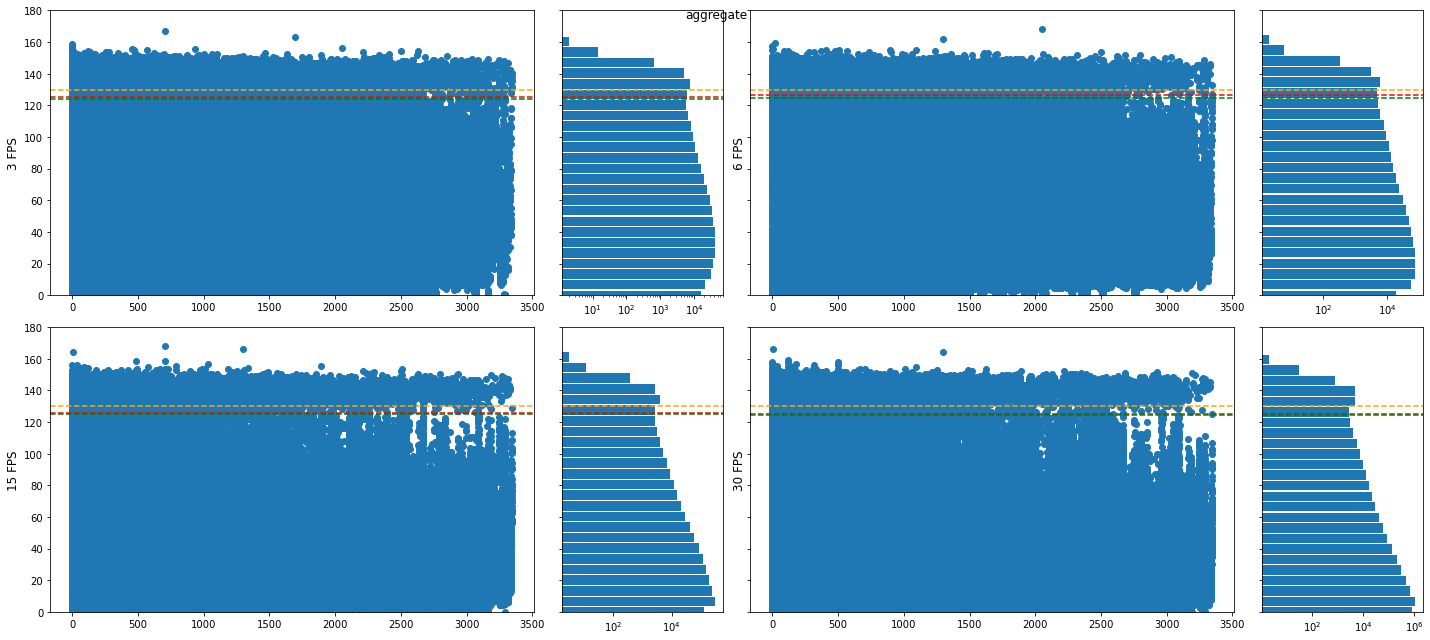

In [4]:
for file_name in data.keys():
    r = len(data[file_name])
    fig, axs = plt.subplots(2, 4, figsize=(20, 9), gridspec_kw={'width_ratios': [3, 1, 3, 1]}, sharey=True, squeeze=False)
    for fps, i, j in [(3, 0, 0), (6, 0, 1), (15, 1, 0), (30, 1, 1)]:
        if fps not in data[file_name]:
            continue
        
        ax1 = axs[i, 2*j]
        ax2 = axs[i, 2*j+1]
        x, y = data[file_name][fps]
        
        h, b = np.histogram(y, 25)
        ax1.scatter(x, y)
        ax2.barh(b[:-1], h, (b[:-1] - b[1:]) * 0.9, log=True, align='center')
        
        threshold_1 = 0.75 * np.max(y)
        ax1.axhline(threshold_1, ls='--', c='red', label=r'\tau_1')
        ax2.axhline(threshold_1, ls='--', c='red', label=r'\tau_1')
        
        yt = y[y > threshold_1]
        threshold_2 = np.mean(yt) - 2 * np.std(yt)
        ax1.axhline(threshold_2, ls='--', c='green', label=r'\tau_2')
        ax2.axhline(threshold_2, ls='--', c='green', label=r'\tau_2')
        
        threshold_3 = 130
        ax1.axhline(threshold_3, ls='--', c='orange', label=r'\tau_3')
        ax2.axhline(threshold_3, ls='--', c='orange', label=r'\tau_3')
        
        ax1.set_ylim(0, 180)
        ax1.set_ylabel(f"{fps} FPS", rotation=90, size='large')
    
    fig.tight_layout()
    fig.suptitle(f'{file_name}')
    plt.savefig(f'images/shot_transition_{file_name}.svg', bbox_inches='tight')
    plt.savefig(f'images/shot_transition_{file_name}.png', bbox_inches='tight')
    
    plt.show()

In [5]:
time_threshold = 1.0

for file_name in file_names:
    if 30 not in data[file_name]:
        continue
    
    x, y = data[file_name][30]
    threshold_1 = 0.75 * np.max(y)
    
    yt = y[y > threshold_1]
    threshold_2 = np.mean(yt) - 2 * np.std(yt)
    
    threshold_3 = 130

    cap = cv2.VideoCapture(video_file.format(name=file_name))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    scale = float(480) / float(max(width, height))
    
    width = int(np.round(scale * width))
    height = int(np.round(scale * height))
    
    print(file_name, scale, width, height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_file.format(name=file_name), fourcc, 30, (3 * width, height))

    threshold = [threshold_1, threshold_2, threshold_3]
    num_shot = [0, 0, 0]
    shot_start = [0, 0, 0]
    for frame, ts, cd in zip(video_read(cap), x, y):
        frame = cv2.resize(frame, None, fx=scale, fy=scale)
        color = [(255, 255, 255)] * 3
        sub_frame = []
        for i, content_threshold in enumerate(threshold):
            if ts - shot_start[i] > time_threshold:
                if cd > content_threshold:
                    shot_start[i] = ts
                    num_shot[i] += 1
            else:
                color[i] = (0, 0, 255)

            seconds = int(ts - shot_start[i])
            minutes = seconds // 60
            seconds = seconds - minutes * 60
            text = f"T:{i} S:{num_shot[i]} {minutes:02d}:{seconds:02d}"
            sub_frame.append(place_text(frame.copy(), text, color[i]))
        frame = np.hstack(sub_frame)
        writer.write(frame)
    writer.release()
    cap.release()

0yTEcgQNoQo 1.0212765957446808 480 368
b85zz8XkVO4 0.6666666666666666 257 480
FD7ASrSrQk4 0.25 480 270
gQY-5f_w6oU 0.375 480 270
